# Data Preparation 

*Notebook Author: Koki Sasagawa*  
*Date: 10/8/2018*

Prepare data for rating prediction task

## Data: 

`reviews.training.json` 
Sample: 
```json
{
 "reviewerID": "AMFIPCYDYWGVT",
 "asin": "B0090SI56Y",
 "reviewerName": "AMRDxn",
 "helpfull": [
 0,
 0
 ],
 "reviewText": "The movie was entertaining and falls in line with the Wolverine story. Nice special effect and good story line. Recommended.",
 "overall": 4,
 "summary": "Entertaining",
 "unixReviewTime": 1387670400,
 "reviewTime": "12 22, 2013"
 }
```
- reviewerID = specific individual making a review
- asin = identifier for the product being reviewed 
- overall = rating on a scale of 1-5 

`reviews.test.unlabeled.csv`  
`reviews.dev.csv`  
`reviews.dev.json`

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Load files

In [2]:
dev_df = pd.read_csv('../raw_data/reviews.dev.csv')
print('Number of rows: {}'.format(dev_df.shape[0]))
dev_df.head()

Number of rows: 169753


,reviewerID,asin,overall
0,A34DNO6UAH67Z0,B000CDSS22,5
1,A3APW42N5MRVWT,6305186774,2
2,A20D9VGCF3P13L,B004LWZW24,5
3,A82LIVYSX6WZ9,B00001U0DM,3
4,A3LRKDF5WU4ZDO,B00005JOZI,3


In [3]:
train_df = pd.read_json('../raw_data/reviews.training.json', lines=True, chunksize=100000)
train_df = pd.concat(train_df)
print('Number of rows: {}'.format(train_df.shape[0]))
train_df.head()

Number of rows: 1358026


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B0090SI56Y,"[0, 0]",4,The movie was entertaining and falls in line w...,"12 22, 2013",AMFIPCYDYWGVT,AMRDxn,Entertaining,1387670400
1,B00005JL99,"[3, 6]",5,One thing to be said about Japanese horror/ext...,"11 19, 2003",A3G602Z4DWDZKS,Matthew King,Absolutely stunning! A battle not to be missed!,1069200000
2,B00109KN0M,"[27, 28]",5,Michelle Pfeiffer gives a brilliant performanc...,"02 13, 2008",A33BOYMVG3U58Y,TV Critic,Michelle Pfeiffer shines,1202860800
3,B00005JMPT,"[3, 4]",5,I wanted to see &quot;The Missing&quot; when i...,"06 18, 2004",ANEDXRFDZDL18,Serene Night,Hard Gritty Western,1087516800
4,B00005AAA9,"[0, 0]",4,I think &#34;Miss Congeniality&#34; is a light...,"10 22, 2013",A1VN7IS16PY024,Amazon Customer,Very entertaining but.....,1382400000


## 2. Prepare Dev Data

In [4]:
# Keep relevant columns for merge with dev set 
train_df = train_df.filter(items=['reviewerID', 'asin', 'overall'], axis=1)

In [5]:
train_df.to_csv('../temp_data/train_set.dev.csv', index=False)

In [6]:
# Find unique number of reviewers and movies
cols = pd.unique(train_df['reviewerID'])
ncols = cols.shape[0]
rows = pd.unique(train_df['asin'])
nrows = rows.shape[0]

print('{} unique reviewers'.format(ncols))
print('First 5 items: {}'.format(cols[:5]))
print('{} unique movies'.format(nrows))
print('First 5 items: {}'.format(rows[:5]))

123952 unique reviewers
First 5 items: ['AMFIPCYDYWGVT' 'A3G602Z4DWDZKS' 'A33BOYMVG3U58Y' 'ANEDXRFDZDL18'
 'A1VN7IS16PY024']
50050 unique movies
First 5 items: ['B0090SI56Y' 'B00005JL99' 'B00109KN0M' 'B00005JMPT' 'B00005AAA9']


In [7]:
reviewerID = set(train_df.reviewerID)
asin = set(train_df.asin)
print('Number of unique reviewID in train_df: {}'.format(len(reviewerID)))
print('Number of unique asin in train_df: {}'.format(len(asin)))

Number of unique reviewID in train_df: 123952
Number of unique asin in train_df: 50050


In [8]:
dev_reviewerID = set(dev_df.reviewerID)
dev_asin = set(dev_df.asin)
print('Number of unique reviewID in dev_df: {}'.format(len(dev_reviewerID)))
print('Number of unique asin in dev_df: {}'.format(len(dev_asin)))

Number of unique reviewID in dev_df: 72853
Number of unique asin in dev_df: 36569


In [9]:
diff_reviewer_ID = dev_reviewerID.difference(reviewerID)
diff_asin = dev_asin.difference(asin)
print('reviewerID\'s not present in train_df: {}'.format(diff_reviewer_ID))
print('asin\'s not present in train_df: {}'.format(diff_asin))

reviewerID's not present in train_df: {'A3UV0B32X7H4GC', 'AJSM8QWA4B8IP', 'A150UCGE9QID39', 'A3G6PW095IFNN5', 'AZTYHKV3MI0YL', 'A3E9C95QHGYKWH', 'A2VGI69KIN0AAH', 'A1D3L5ICB2KE0F'}
asin's not present in train_df: {'B004A30AW6'}


In [10]:
remove_cols = dev_df.loc[dev_df['reviewerID'].isin(diff_reviewer_ID) | dev_df['asin'].isin(diff_asin)].index.tolist()
print('Number of rows to remove: {}'.format(len(remove_cols)))
dev_df.drop(remove_cols, axis=0, inplace=True)
print('Number of rows in dev_df after drop: {}'.format(dev_df.shape[0]))

Number of rows to remove: 29
Number of rows in dev_df after drop: 169724


In [11]:
dev_df.to_csv('../temp_data/dev_set.dev.csv', index=False)

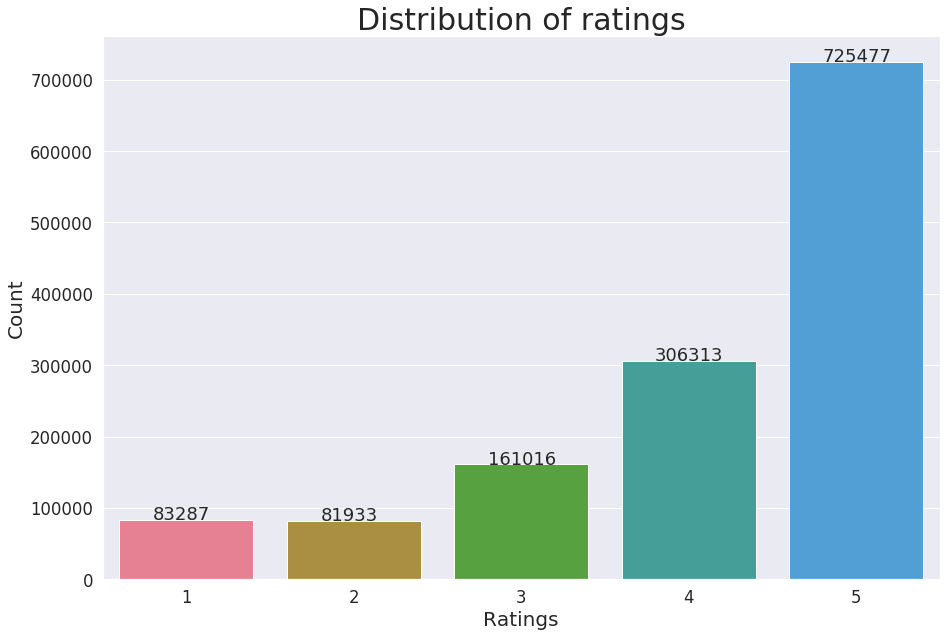

In [12]:
# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,10))

# Create plot
g = sns.countplot(x='overall', data=train_df)

# Add plot labels 
g.set_xlabel('Ratings', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Distribution of ratings', fontsize=30)
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()))

# Save File
fig = g.get_figure()
fig.savefig('../images/{}.png'.format('distribution_of_ratings'))

Distribution of ratings seem to be left skewed and mostly high. 

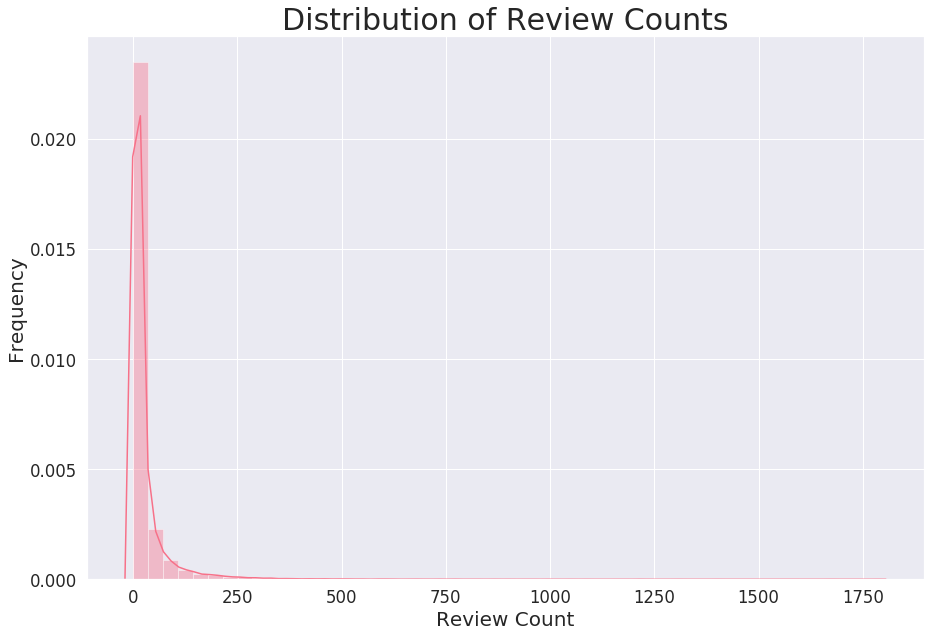

In [14]:
plt.figure(figsize=(15,10))

# Create plot
g = sns.distplot(train_df['asin'].value_counts().tolist())

# Add plot labels 
g.set_xlabel('Review Count', fontsize=20)
g.set_ylabel('Frequency', fontsize=20)
g.axes.set_title('Distribution of Review Counts', fontsize=30)

# Save File
fig = g.get_figure()
fig.savefig('../images/{}.png'.format('distribution_of_review_counts'))

The distribution of review counts is very right skewed. There are 50050 unique movie titles and 123952 reviewers in the movie ratings data. If every reviewer were to rate every movie, each movie would get 123952 reviews which would be a total of 6203797600 reviews. However, in our data there are only 1358026 reviews, and our histogram reveals that most films only have a few hundred reviews. If we were to represent this as a dense movie x reviewer matrix, it will result in many cells with 0's, therefore it is better to represent this using a sparse matrix. 

## 3. Make sparse matrix

In [12]:
# Set triplet data for sparse matrix
# Convert the values in columns reviewerID and asin to obtain numeric representation
row_indices, row_uniques = pd.factorize(train_df['asin'])
col_indices, col_uniques = pd.factorize(train_df['reviewerID'])
val = train_df['overall']

# Create COO matrix from three arrays 
train_coo_matrix = sparse.coo_matrix((val, (row_indices, col_indices)))

In [13]:
print('Sparse matrix has following dimensions: {}'.format(train_coo_matrix.shape))
print('Number of stored values: {}'.format(train_coo_matrix.nnz))

Sparse matrix has following dimensions: (50050, 123952)
Number of stored values: 1358026


In [14]:
sparse.save_npz('../temp_data/movie_reviews.dev.npz', train_coo_matrix)

## 4. Map index to asin and reviewerID

In [15]:
row_index_to_movies = {k: v for k, v in zip(row_uniques, pd.unique(row_indices))}
col_index_to_reviewer = {k: v for k, v in zip(col_uniques, pd.unique(col_indices))}

In [16]:
with open('../temp_data/movie_index_map.dev.p', 'wb') as fp:
    pickle.dump(row_index_to_movies, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('../temp_data/reviewer_index_map.dev.p', 'wb') as fp:
    pickle.dump(col_index_to_reviewer, fp, protocol=pickle.HIGHEST_PROTOCOL)

## 5. Prepare Full Data

In [21]:
# Load dev set again as we removed items from it previously
dev_df = pd.read_csv('../raw_data/reviews.dev.csv')
print('Number of rows: {}'.format(dev_df.shape[0]))
dev_df.head()

Number of rows: 169753


,reviewerID,asin,overall
0,A34DNO6UAH67Z0,B000CDSS22,5
1,A3APW42N5MRVWT,6305186774,2
2,A20D9VGCF3P13L,B004LWZW24,5
3,A82LIVYSX6WZ9,B00001U0DM,3
4,A3LRKDF5WU4ZDO,B00005JOZI,3


In [22]:
full_train_df = pd.concat([train_df, dev_df])
print('Number of rows: {}'.format(full_train_df.shape[0]))
full_train_df.head()

Number of rows: 1527779


,reviewerID,asin,overall
0,AMFIPCYDYWGVT,B0090SI56Y,4
1,A3G602Z4DWDZKS,B00005JL99,5
2,A33BOYMVG3U58Y,B00109KN0M,5
3,ANEDXRFDZDL18,B00005JMPT,5
4,A1VN7IS16PY024,B00005AAA9,4


In [23]:
full_train_df.to_csv('../temp_data/full_train_set.csv', index=False)

In [24]:
# Find unique number of reviewers and movies
cols = pd.unique(full_train_df['reviewerID'])
ncols = cols.shape[0]
rows = pd.unique(full_train_df['asin'])
nrows = rows.shape[0]

print('{} unique reviewers'.format(ncols))
print('First 5 items: {}'.format(cols[:5]))
print('{} unique movies'.format(nrows))
print('First 5 items: {}'.format(rows[:5]))

123960 unique reviewers
First 5 items: ['AMFIPCYDYWGVT' 'A3G602Z4DWDZKS' 'A33BOYMVG3U58Y' 'ANEDXRFDZDL18'
 'A1VN7IS16PY024']
50051 unique movies
First 5 items: ['B0090SI56Y' 'B00005JL99' 'B00109KN0M' 'B00005JMPT' 'B00005AAA9']


By combining the dev set with the train set, we have gained 8 new reviewers and 1 new movie. 

## 6. Make sparse matrix

In [25]:
# Set triplet data for sparse matrix
# Convert the values in columns reviewerID and asin to obtain numeric representation
row_indices, row_uniques = pd.factorize(full_train_df['asin'])
col_indices, col_uniques = pd.factorize(full_train_df['reviewerID'])
val = full_train_df['overall']

# Create COO matrix from three arrays 
train_coo_matrix = sparse.coo_matrix((val, (row_indices, col_indices)))

In [26]:
print('Sparse matrix has following dimensions: {}'.format(train_coo_matrix.shape))
print('Number of stored values: {}'.format(train_coo_matrix.nnz))

Sparse matrix has following dimensions: (50051, 123960)
Number of stored values: 1527779


In [27]:
sparse.save_npz('../temp_data/movie_reviews.npz', train_coo_matrix)

## 7. Map index to asin and reviewerID

In [28]:
row_index_to_movies = {k: v for k, v in zip(row_uniques, pd.unique(row_indices))}
col_index_to_reviewer = {k: v for k, v in zip(col_uniques, pd.unique(col_indices))}

In [29]:
with open('../temp_data/movie_index_map.p', 'wb') as fp:
    pickle.dump(row_index_to_movies, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('../temp_data/reviewer_index_map.p', 'wb') as fp:
    pickle.dump(col_index_to_reviewer, fp, protocol=pickle.HIGHEST_PROTOCOL)